<h1 align='center'><b>Машинное обучение в бизнесе<b></h1>

<h1 align='left'>Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)</h1>

<h2 align='center'>Домашняя работа</h2>

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [252]:
# !pip install razdel
# !pip install pymorphy2
# !pip install --upgrade pip

In [253]:
import pandas as pd
import numpy as np

# пакет для того, чтобы создавать словарь, механизм поддерживающий словарь
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize

import pymorphy2

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline



INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Наши новости

In [254]:
news = pd.read_csv('./data/materials.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [255]:
users = pd.read_csv('./data/users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [256]:
# загружаем стоп-слова
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [257]:
len(stopword_ru)

151

In [258]:
# подгружаем стоп-слова из ранее заготовленного файла
with open('./data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    f.close()
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [259]:
# stopword_ru[-520]

In [260]:

def clean_text(text):
    """
    Очистка текста
    на выходе очищенный текст
    """
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[|]|/|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'\xad|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)

    return text

cache = {}

def lemmitization(text):
    """
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    """

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': #[2]
            w = w[1:]
        if len(w)>1: #[3]
            if w in cache: #[4]
                words_lem.append(cache[w])
            else: #[5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] #[6]

    return words_lem_without_stopwords

In [261]:
%%time
#Запускаем очистку текста.

news['title'] = news['title'].parallel_apply(lambda x: clean_text(x), 1)


CPU times: user 682 ms, sys: 244 ms, total: 926 ms
Wall time: 10.2 s


In [262]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].parallel_apply(lambda x: lemmitization(x), 1)

CPU times: user 1.32 s, sys: 323 ms, total: 1.65 s
Wall time: 1min 11s


А теперь в 3 строчки обучим нашу модель

In [263]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

common_dictionary - это словарь наших слов

In [264]:
print(common_dictionary)

Dictionary<135647 unique tokens: ['александр', 'алексей', 'андрей', 'армеец', 'банк']...>


Запускаем обучение

In [265]:
n_topics = 25

In [266]:
%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary) #, passes=10)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


In [267]:
from gensim.test.utils import datapath
# Сохраняем модель (только вот куда(?))
temp_file = datapath('model.lda')
lda.save(temp_file)

In [268]:
# # Загружаем предварительно обученную модель
# lda = LdaModel.load(temp_file)

In [269]:
# Создаем новый корпус из ранее не видимых документов
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.06431531),
 (4, 0.36037144),
 (6, 0.06193685),
 (10, 0.18754058),
 (11, 0.20095697),
 (21, 0.10426037)]

In [270]:
x=lda.show_topics(num_topics=n_topics, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Ниже код печатает слова, соответствующие каждой из тем
for topic, words in topics_words:
    print('topic_{}: '.format(topic)+' '.join(words))

topic_0: расчёт миссия японский продолжительность знаменитый производить формироваться
topic_1: военный население район произойти тело погибнуть данные
topic_2: рейтинг вирус место франция лекарство превысить греция
topic_3: торговый участок акционер донбасс киев индустрия выручка
topic_4: городской океан лёд сердце святой австралийский рисунок
topic_5: турция квартира турецкий восток маршрут добраться лагерь
topic_6: взрыв кровь обнаружить фотография обращение препарат помещение
topic_7: бизнесмен девочка соцсеть горожанин случайный рим укрепить
topic_8: млн тыс составить цена эксперимент налог стоимость
topic_9: мужчина праздник южный солнце день мероприятие юг
topic_10: всё исследование новый первый большой научный очень
topic_11: станция день житель рак первый космос россия
topic_12: сша санкция млрд объект территория северный американский
topic_13: фонд продукция мальчик рекомендовать вино сотрудничать альянс
topic_14: ракета смерть поверхность высота метр сооружение секунда
topic

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [271]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topics):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

Получаем векторное представление наших статей

In [272]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(n_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(n_topics)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.015145,0.0,0.000000,0.0,0.030651,0.0,0.00000,0.0,0.0,...,0.03101,0.0,0.0,0.00000,0.0,0.0,0.490606,0.126166,0.0,0.298815
1,4896,0.000000,0.0,0.000000,0.0,0.250680,0.0,0.51244,0.0,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.213715,0.0,0.000000
2,4897,0.064304,0.0,0.000000,0.0,0.360472,0.0,0.06195,0.0,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.104340,0.000000,0.0,0.000000
3,4898,0.000000,0.0,0.085839,0.0,0.060915,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.049246,0.000000,0.0,0.000000
4,4899,0.000000,0.0,0.000000,0.0,0.136648,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.19969,0.0,0.0,0.086628,0.000000,0.0,0.551547


### Следующий шаг - векторные представления пользователей

In [273]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [274]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(n_topics)]].values))

In [275]:
# doc_dict[293622]

In [276]:
user_articles_list = users['articles'].iloc[33]

## 1. get_user_embedding_mean - исходный вариант функции через среднее

In [277]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [278]:
get_user_embedding_mean(user_articles_list)

array([0.        , 0.11858994, 0.00711265, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01248863, 0.        ,
       0.12017412, 0.05684497, 0.01242065, 0.        , 0.01871478,
       0.        , 0.01908869, 0.        , 0.01546347, 0.00551855,
       0.01330779, 0.13305069, 0.02947531, 0.0282043 , 0.39403231])

In [279]:
# users['articles'].iloc[33]

In [280]:
# " ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [281]:
user_embeddings_1 = pd.DataFrame([i for i in users['articles'].parallel_apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_1.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_1['uid'] = users['uid'].values
user_embeddings_1 = user_embeddings_1[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.093196,0.026118,0.012441,0.004505,0.000000,0.009162,0.00000,0.082388,...,0.000000,0.000000,0.037342,0.000000,0.000000,0.028178,0.054757,0.087270,0.092851,0.303790
1,u108690,0.003416,0.149522,0.004650,0.006678,0.000000,0.000000,0.007065,0.00213,0.024984,...,0.007023,0.007464,0.014566,0.005441,0.000000,0.041511,0.095842,0.021348,0.046703,0.325732
2,u108339,0.000000,0.223454,0.006811,0.000000,0.000000,0.005406,0.010286,0.00000,0.056033,...,0.005528,0.034484,0.001926,0.003530,0.006532,0.006749,0.053439,0.029127,0.010918,0.289208


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [282]:
target = pd.read_csv('./data/users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [283]:
X_mean = pd.merge(user_embeddings_1, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.093196,0.026118,0.012441,0.004505,0.000000,0.009162,0.00000,0.082388,...,0.000000,0.037342,0.000000,0.000000,0.028178,0.054757,0.087270,0.092851,0.303790,0
1,u108690,0.003416,0.149522,0.004650,0.006678,0.000000,0.000000,0.007065,0.00213,0.024984,...,0.007464,0.014566,0.005441,0.000000,0.041511,0.095842,0.021348,0.046703,0.325732,1
2,u108339,0.000000,0.223454,0.006811,0.000000,0.000000,0.005406,0.010286,0.00000,0.056033,...,0.034484,0.001926,0.003530,0.006532,0.006749,0.053439,0.029127,0.010918,0.289208,1


In [284]:
#разделим данные на train/test

X_train, X_test, y_train, y_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(n_topics)]], X_mean['churn'], random_state=42)

In [285]:
logreg_mean = LogisticRegression()
#обучим
logreg_mean.fit(X_train, y_train)

LogisticRegression()

In [286]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_test)[:, 1]
preds_mean[:10]

array([0.00171172, 0.11777293, 0.03675913, 0.04636225, 0.04958251,
       0.0795096 , 0.01076919, 0.0725668 , 0.28719892, 0.10164082])

### Рассчитаем Precision, Recall, F_score

In [287]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, preds_mean)
fscore_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
# locate the index of the largest f score
ix = np.argmax(fscore_1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_1[ix],
                                                                        fscore_1[ix],
                                                                        precision_1[ix],
                                                                        recall_1[ix]))

Best Threshold=0.229101, F-Score=0.711, Precision=0.651, Recall=0.783


In [288]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1641  106]
 [  56  197]]


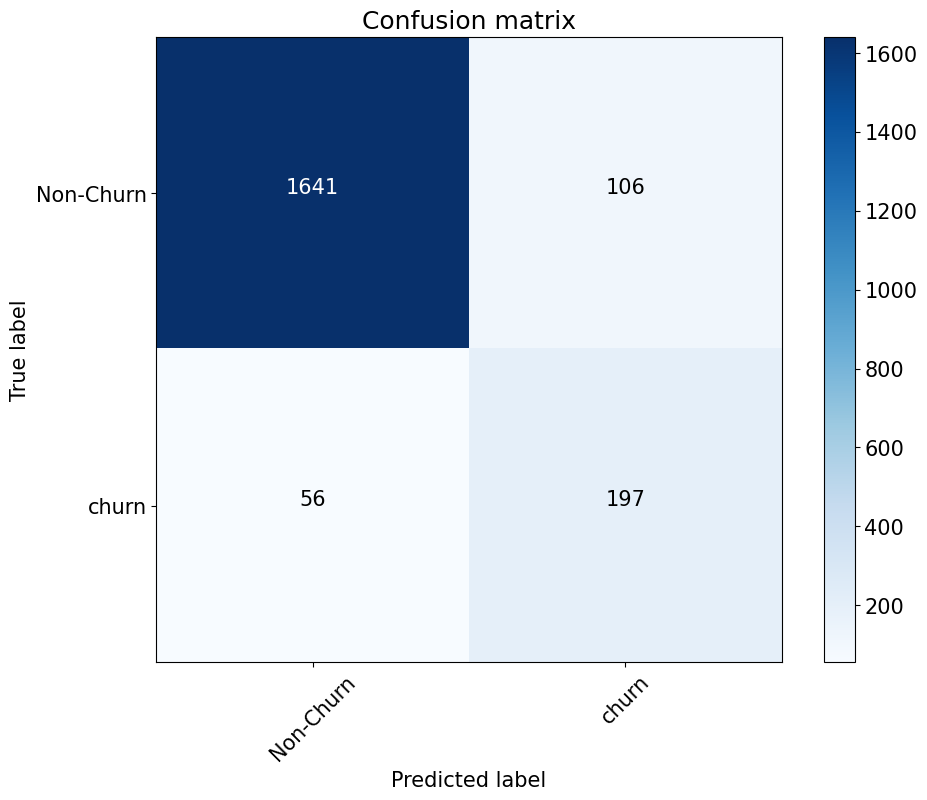

In [289]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_mean = confusion_matrix(y_test, preds_mean>thresholds_1[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_mean, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [290]:
roc_auc_score_mean = roc_auc_score(y_test, preds_mean)
roc_auc_score_mean

0.9504741046763395

## 2. get_user_embedding_median - вариант функции через медиану

In [291]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [292]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.13160538, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06445942, 0.02642022, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04255454, 0.        , 0.01905884, 0.41589794])

In [293]:
user_embeddings_2 = pd.DataFrame([i for i in users['articles'].parallel_apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_2.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_2['uid'] = users['uid'].values
user_embeddings_2 = user_embeddings_2[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.044582,0.0,0.0,0.0,0.0,0.0,0.0,0.013092,...,0.0,0.000000,0.028109,0.0,0.0,0.000000,0.027102,0.027197,0.083711,0.300011
1,u108690,0.0,0.133617,0.0,0.0,0.0,0.0,0.0,0.0,0.019131,...,0.0,0.005086,0.000000,0.0,0.0,0.043449,0.088676,0.017053,0.008971,0.338636
2,u108339,0.0,0.224098,0.0,0.0,0.0,0.0,0.0,0.0,0.052492,...,0.0,0.020408,0.000000,0.0,0.0,0.005815,0.045289,0.008636,0.008589,0.344031


In [294]:
target = pd.read_csv('./data/users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [295]:
X_median = pd.merge(user_embeddings_2, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.044582,0.0,0.0,0.0,0.0,0.0,0.0,0.013092,...,0.000000,0.028109,0.0,0.0,0.000000,0.027102,0.027197,0.083711,0.300011,0
1,u108690,0.0,0.133617,0.0,0.0,0.0,0.0,0.0,0.0,0.019131,...,0.005086,0.000000,0.0,0.0,0.043449,0.088676,0.017053,0.008971,0.338636,1
2,u108339,0.0,0.224098,0.0,0.0,0.0,0.0,0.0,0.0,0.052492,...,0.020408,0.000000,0.0,0.0,0.005815,0.045289,0.008636,0.008589,0.344031,1


In [296]:
X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(n_topics)]], X_median['churn'], random_state=42)

In [297]:
logreg_median = LogisticRegression()
#обучим
logreg_median.fit(X_train, y_train)

LogisticRegression()

In [298]:
preds_median = logreg_median.predict_proba(X_test)[:, 1]
preds_median[:10]

array([0.0009899 , 0.08926421, 0.03398777, 0.02046391, 0.03319567,
       0.06765402, 0.00199315, 0.05467006, 0.17161707, 0.18380745])

### Рассчитаем Precision, Recall, F_score

In [299]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, preds_median)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_2[ix],
                                                                        fscore_2[ix],
                                                                        precision_2[ix],
                                                                        recall_2[ix]))

Best Threshold=0.267394, F-Score=0.718, Precision=0.717, Recall=0.719


Confusion matrix, without normalization
[[1675   72]
 [  72  181]]


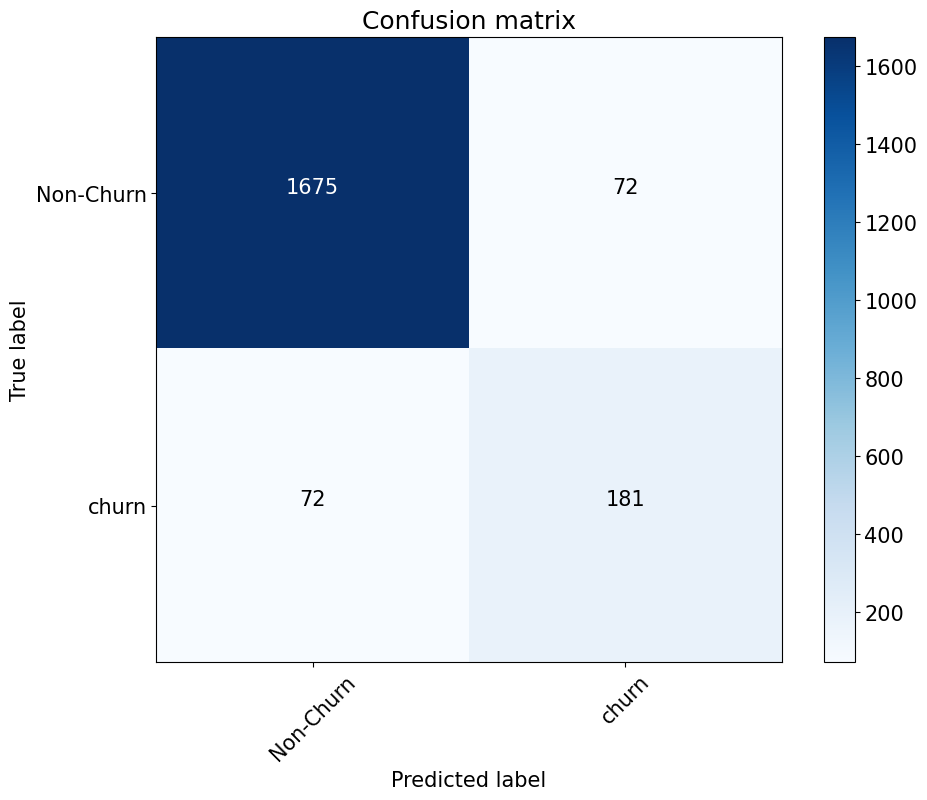

In [300]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_median = confusion_matrix(y_test, preds_median>thresholds_2[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_median, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [301]:
roc_auc_score_median = roc_auc_score(y_test, preds_median)
roc_auc_score_median

0.9602322219230708

## 3. get_user_embedding_max - вариант функции через медиану

In [302]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [303]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.27958256, 0.04267589, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07493177, 0.        ,
       0.33808103, 0.18504772, 0.07452392, 0.        , 0.09951842,
       0.        , 0.11453215, 0.        , 0.09278079, 0.0331113 ,
       0.0648357 , 0.52372015, 0.1419116 , 0.07078895, 0.72468597])

In [304]:
user_embeddings_3 = pd.DataFrame(
    [i for i in users['articles'].parallel_apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_3.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_3['uid'] = users['uid'].values
user_embeddings_3 = user_embeddings_3[['uid'] + ['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings_3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.256951,0.107323,0.074643,0.027032,0.000000,0.054970,0.000000,0.297090,...,0.000000,0.000000,0.110474,0.000000,0.000000,0.097439,0.173937,0.409437,0.221259,0.487404
1,u108690,0.020494,0.336507,0.014991,0.040067,0.000000,0.000000,0.030790,0.012778,0.065690,...,0.042140,0.021561,0.065202,0.018034,0.000000,0.090773,0.162297,0.051880,0.231820,0.495216
2,u108339,0.000000,0.390168,0.040865,0.000000,0.000000,0.032434,0.061717,0.000000,0.114277,...,0.033169,0.096622,0.011557,0.021179,0.039189,0.014608,0.104411,0.114889,0.025913,0.423217


In [305]:
target = pd.read_csv('./data/users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [306]:
X_max = pd.merge(user_embeddings_3, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.256951,0.107323,0.074643,0.027032,0.000000,0.054970,0.000000,0.297090,...,0.000000,0.110474,0.000000,0.000000,0.097439,0.173937,0.409437,0.221259,0.487404,0
1,u108690,0.020494,0.336507,0.014991,0.040067,0.000000,0.000000,0.030790,0.012778,0.065690,...,0.021561,0.065202,0.018034,0.000000,0.090773,0.162297,0.051880,0.231820,0.495216,1
2,u108339,0.000000,0.390168,0.040865,0.000000,0.000000,0.032434,0.061717,0.000000,0.114277,...,0.096622,0.011557,0.021179,0.039189,0.014608,0.104411,0.114889,0.025913,0.423217,1


In [307]:
X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(n_topics)]], X_max['churn'], random_state=42)

In [308]:
logreg_max = LogisticRegression()
#обучим
logreg_max.fit(X_train, y_train)

LogisticRegression()

In [309]:
preds_max = logreg_max.predict_proba(X_test)[:, 1]
preds_max[:10]

array([1.51873071e-04, 2.53660609e-02, 2.08773178e-03, 2.45941471e-02,
       1.81176259e-02, 1.91895623e-02, 1.22258157e-03, 1.60549494e-02,
       3.93221545e-01, 1.75132357e-01])

### Рассчитаем Precision, Recall, F_score

In [310]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, preds_max)
fscore_3 = (2 * precision_3 * recall_3) / (precision_3 + recall_3)
# locate the index of the largest f score
ix = np.argmax(fscore_3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_3[ix],
                                                                        fscore_3[ix],
                                                                        precision_3[ix],
                                                                        recall_3[ix]))

Best Threshold=0.311484, F-Score=0.780, Precision=0.774, Recall=0.787


Confusion matrix, without normalization
[[1689   58]
 [  55  198]]


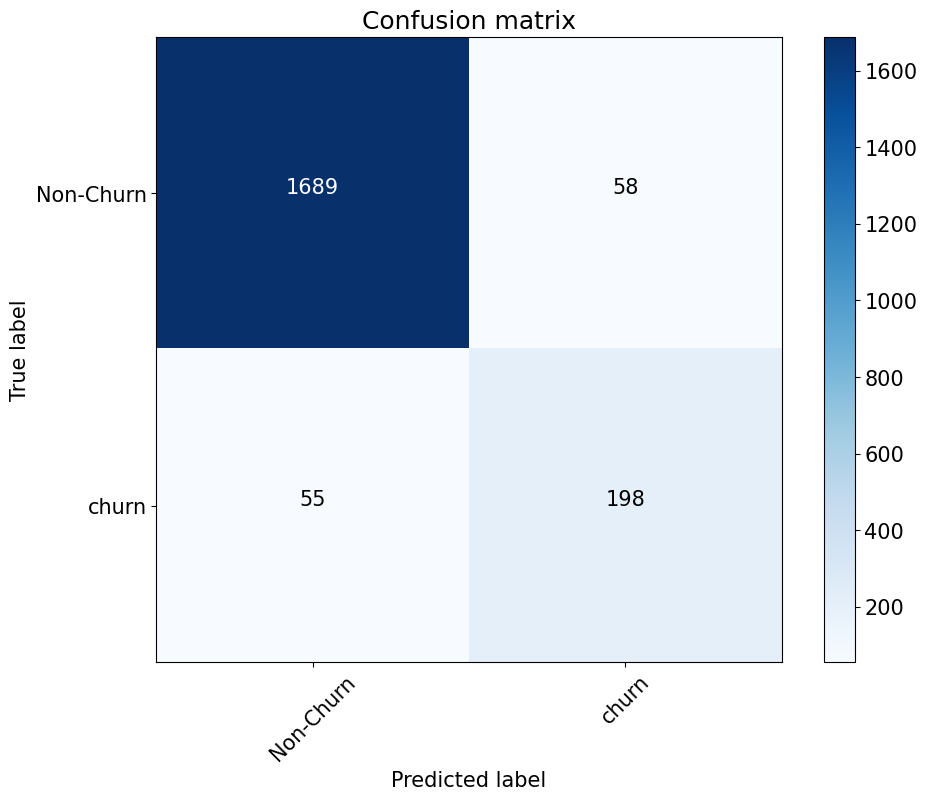

In [311]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_max>thresholds_3[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [312]:
roc_auc_score_max = roc_auc_score(y_test, preds_max)
roc_auc_score_max

0.9697165779393698

## 4. TF-IDF

In [313]:
from sklearn.feature_extraction.text import TfidfTransformer

In [314]:
doc_id = topic_matrix['doc_id']

In [315]:
idf_transformer = TfidfTransformer()

In [316]:
idf_transformer.fit(topic_matrix.drop(columns='doc_id').transpose())

TfidfTransformer()

In [317]:
idf = idf_transformer.idf_
# idf

In [318]:
dict_idf = dict(zip(doc_id, idf))

In [319]:
def get_user_embedding_idf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] * dict_idf[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [320]:
user_embeddings_4 = pd.DataFrame(
    [i for i in users['articles'].parallel_apply(lambda x: get_user_embedding_idf(x), 1)])
user_embeddings_4.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings_4['uid'] = users['uid'].values
user_embeddings_4 = user_embeddings_4[['uid'] + ['topic_{}'.format(i) for i in range(n_topics)]]
# user_embeddings_4.head(3)

In [321]:
target = pd.read_csv('./data/users_churn.csv')

In [322]:
X_idf = pd.merge(user_embeddings_4, target, 'left')
# X_idf.head(3)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X_idf[['topic_{}'.format(i) for i in range(n_topics)]], X_idf['churn'], random_state=42)

In [324]:
logreg_idf = LogisticRegression()
#обучим
logreg_idf.fit(X_train, y_train)

LogisticRegression()

In [325]:
preds_idf = logreg_idf.predict_proba(X_test)[:, 1]
# preds_idf[:10]

### Рассчитаем Precision, Recall, F_score

In [326]:
precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, preds_idf)
fscore_4 = (2 * precision_4 * recall_4) / (precision_4 + recall_4)
# locate the index of the largest f score
ix = np.argmax(fscore_3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_4[ix],
                                                                        fscore_4[ix],
                                                                        precision_4[ix],
                                                                        recall_4[ix]))

Best Threshold=0.315391, F-Score=0.875, Precision=0.868, Recall=0.881


Confusion matrix, without normalization
[[1714   33]
 [  30  223]]


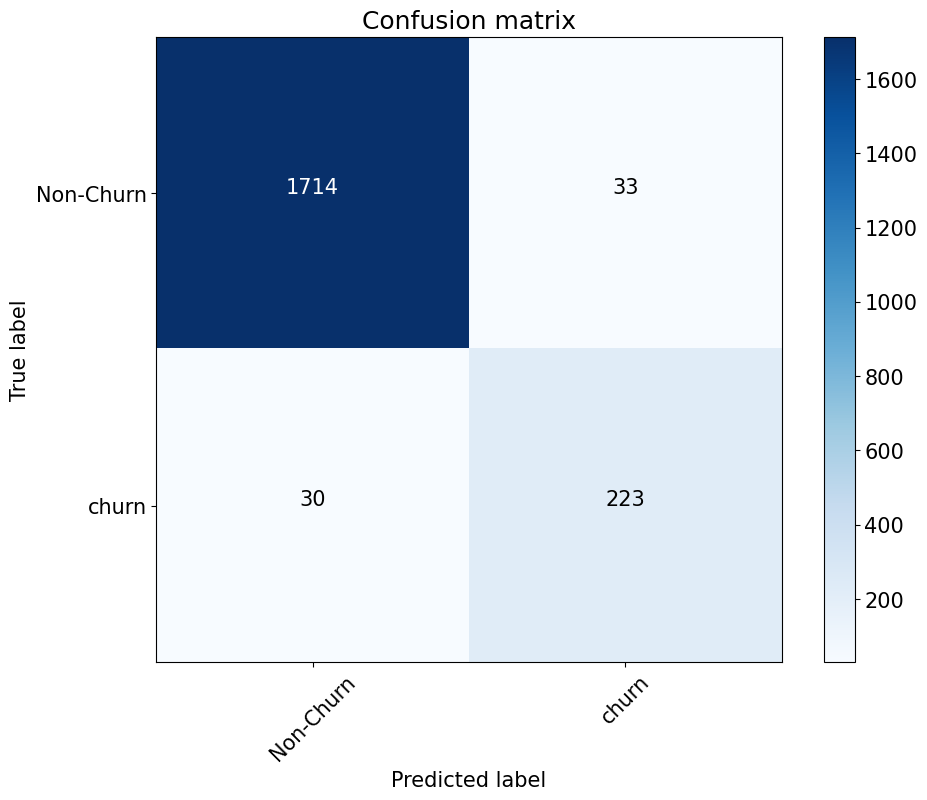

In [327]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_idf>thresholds_4[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [328]:
roc_auc_score_idf = roc_auc_score(y_test, preds_idf)
roc_auc_score_idf

0.9893436744187099

## ИТОГИ:

In [329]:
roc_auc_score_mean

0.9504741046763395

In [330]:
roc_auc_score_median

0.9602322219230708

In [331]:
roc_auc_score_max

0.9697165779393698

In [332]:
roc_auc_score_idf

0.9893436744187099

In [333]:
mean_column = {'Threshold': round(thresholds_1[ix], 3),
               'Precision': round(precision_1[ix], 3),
               'Recall': round(recall_1[ix], 3),
               'F-score': round(fscore_1[ix], 3),
               'ROC-AUC': round(roc_auc_score_mean, 4)}

median_column = {'Threshold': round(thresholds_2[ix], 3),
                 'Precision': round(precision_2[ix], 3),
                 'Recall': round(recall_2[ix], 3),
                 'F-score': round(fscore_2[ix], 3),
                 'ROC-AUC': round(roc_auc_score_median, 4)}

max_column = {'Threshold': round(thresholds_3[ix], 3),
              'Precision': round(precision_3[ix], 3),
              'Recall': round(recall_3[ix], 3),
              'F-score': round(fscore_3[ix], 3),
              'ROC-AUC': round(roc_auc_score_max, 4)}

idf_column = {'Threshold': round(thresholds_4[ix], 3),
              'Precision': round(precision_4[ix], 3),
              'Recall': round(recall_4[ix], 3),
              'F-score': round(fscore_4[ix], 3),
              'ROC-AUC': round(roc_auc_score_idf, 4)}

In [334]:
generalized_table = {'Mean': mean_column,
                     'Median': median_column,
                     'Max': max_column,
                     'IDF': idf_column
}
pd.DataFrame(data=generalized_table).T

,Threshold,Precision,Recall,F-score,ROC-AUC
Mean,0.256,0.700,0.711,0.706,0.9505
Median,0.266,0.708,0.719,0.714,0.9602
Max,0.311,0.774,0.787,0.780,0.9697
IDF,0.315,0.868,0.881,0.875,0.9893


### Вывод:

Так как нас интересуют более редкие данные за счёт их информативности, то:
__Mean__ показал себя хуже всех, так как сглаживает данные, и они становятся менее информативны;
__Median__ чуть лучше, но не учитывает редкие данные;
__Max__ показал лучший результат по сравнению с Mean и Median, он учитывает редкие значения, но грубо, теряя другую информацию,
__IDF__ отработал лучше всех, так как использовал точные коэффициенты для значений, в зависимости от их редкости.